In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt 
import geopandas as gpd
import osmnx as ox
import itertools as it
%matplotlib inline

# Preprocessing

## 1. Graph from OSM (Kota Yogyakarta, Indonesia)

In [2]:
# Street networks from a geocode location.
G = ox.graph.graph_from_place("Kota Yogyakarta, Indonesia", network_type='drive', simplify=True)

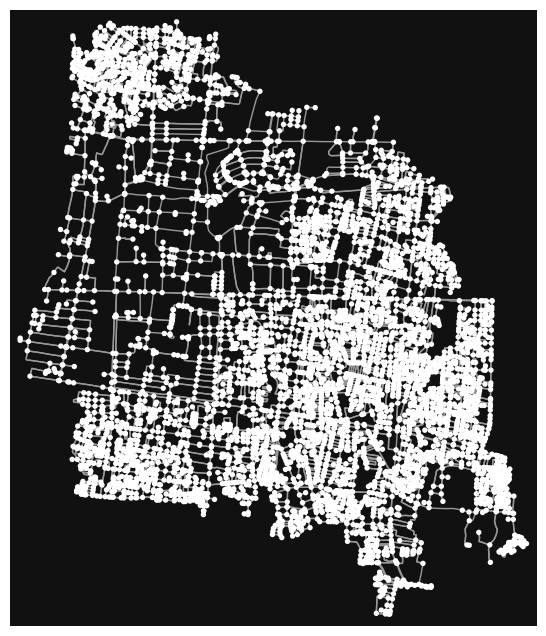

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [3]:
# Visualisation
ox.plot_graph(G)

## Origin Destination's Nodes Location

### Inputting OD's Geometry

In [4]:
#Pakualaman is not defined in OpenStreetMap, merging the geometry that constitute Pakualaman.
pakualaman = ["Gunung ketur, Kota Yogyakarta, Indonesia","Bausasran, Kota Yogyakarta, Indonesia",
              "Pakualaman, Kota Yogyakarta, Indonesia", 
              "Batas Wilayah RW 02 Kelurahan Gunungketur, Kota Yogyakarta, Indonesia"]
pakualaman = ox.geocode_to_gdf(pakualaman)
pakualaman = pakualaman.dissolve()
pakualaman = pakualaman.replace("Gunung ketur, Yogyakarta, Special Region of Yogyakarta, Indonesia",
                                "Pakualaman, Yogyakarta, Special Region of Yogyakarta, Indonesia")
display(pakualaman)

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((110.37750 -7.79732, 110.37749 -7.797...",-7.797324,-7.804723,110.380675,110.373041,298368056,relation,5615711,-7.801033,110.378709,"Pakualaman, Yogyakarta, Special Region of Yogy...",boundary,administrative,0.77


(427358.0889348225, 434946.5295682836, -867085.2089826264, -858130.7770321547)

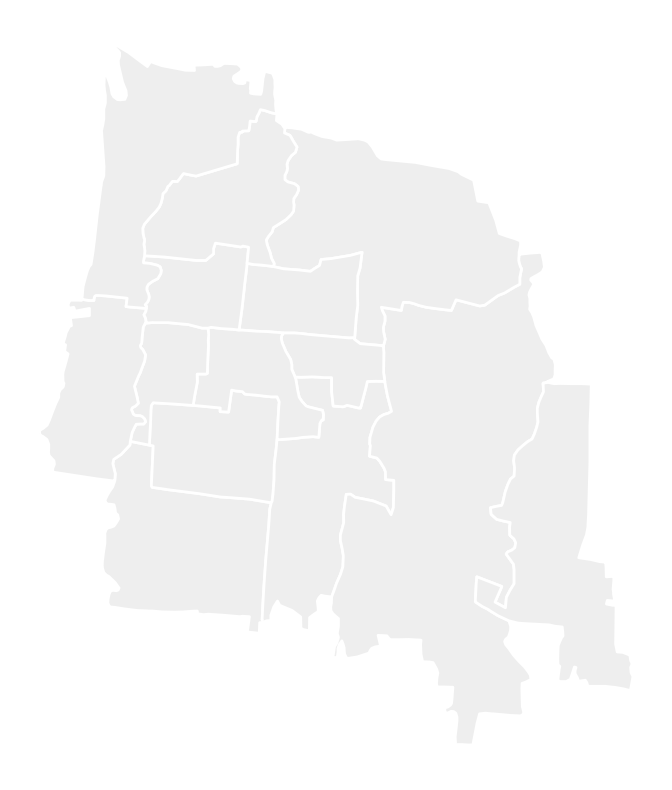

In [5]:
#Other location used as inner OD.
places = ["Mantrijeron, Kota Yogyakarta, Indonesia","Kraton, Kota Yogyakarta, Indonesia",
          "Mergangsan, Kota Yogyakarta, Indonesia","Umbulharjo, Kota Yogyakarta, Indonesia",
          "Kotagede, Kota Yogyakarta, Indonesia","Gondokusuman, Kota Yogyakarta, Indonesia",
          "Danurejan, Kota Yogyakarta, Indonesia", "Gondomanan, Kota Yogyakarta, Indonesia",
          "Ngampilan, Kota Yogyakarta, Indonesia", "Wirobrajan, Kota Yogyakarta, Indonesia",
          "Gedongtengen, Kota Yogyakarta, Indonesia", "Jetis, Kota Yogyakarta, Indonesia",
          "Tegalrejo, Kota Yogyakarta, Indonesia"]

#Polygon of the places.
places = ox.geocode_to_gdf(places)

#Concatenating pakualaman to the data.
places = pd.concat([places.iloc[:7], pakualaman, places.iloc[7:]], ignore_index=True)

places = ox.project_gdf(places)
fig, ax = plt.subplots(figsize=(20, 10))
places.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
ax.axis('off')

(311271.23004651885, 531461.0512117816, -914449.9946570757, -748115.8121198618)

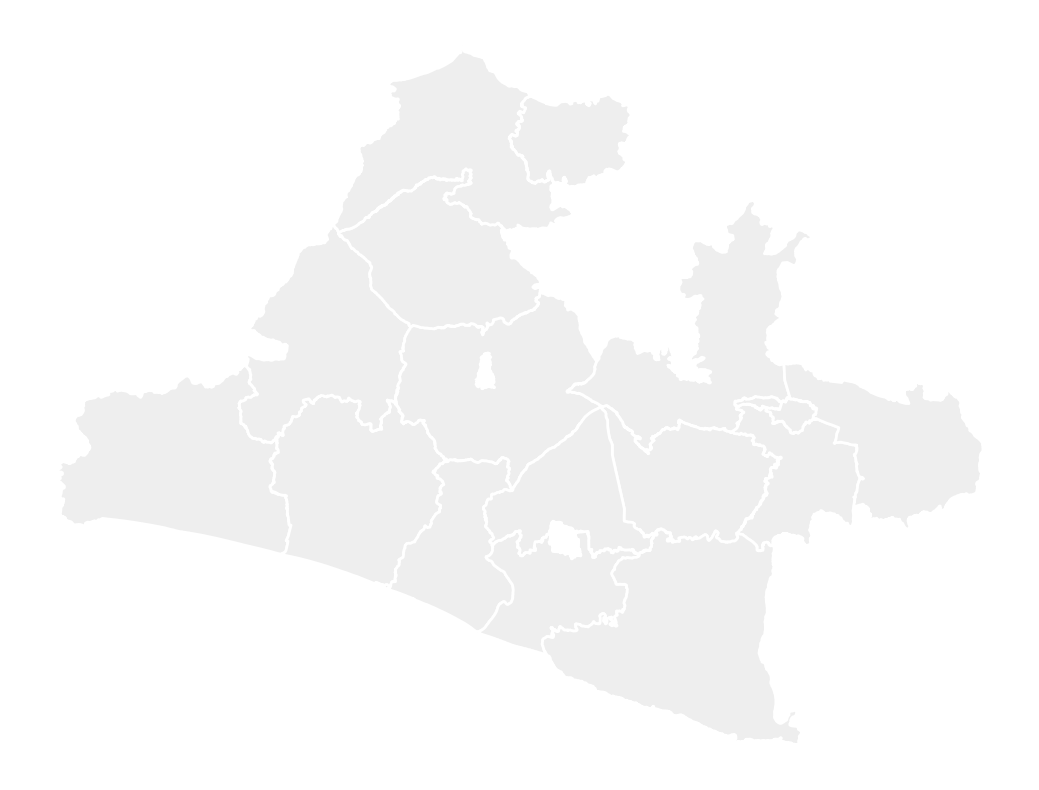

In [6]:
places_outer = ["Kebumen, Jawa Tengah, Indonesia","Purworejo, Jawa Tengah, Indonesia",
          "Wonosobo, Jawa Tengah, Indonesia","Magelang, Jawa Tengah, Indonesia",
          "Boyolali, Jawa Tengah, Indonesia","Klaten, Jawa Tengah, Indonesia",
          "Sukoharjo, Jawa Tengah, Indonesia","Karanganyar, Jawa Tengah, Indonesia",
          "Semarang, Jawa Tengah, Indonesia", "Temanggung, Jawa Tengah, Indonesia",
          "Kendal, Jawa Tengah, Indonesia",
          "Surakarta, Jawa Tengah, Indonesia","Kulon Progo, Daerah Istimewa Yogyakarta, Indonesia",
          "Bantul, Daerah Istimewa Yogyakarta, Indonesia",
          "Kabupaten Gunung Kidul, Daerah Istimewa Yogyakarta, Indonesia",
          "Sleman Regency, Daerah Istimewa Yogyakarta, Indonesia"]

places_outer = ox.geocode_to_gdf(places_outer)

places_outer = ox.project_gdf(places_outer)
fig, ax = plt.subplots(figsize=(20, 10))
places_outer.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
ax.axis('off')

Text(0.5, 1.0, 'OD nodes in Kota Yogyakarta')

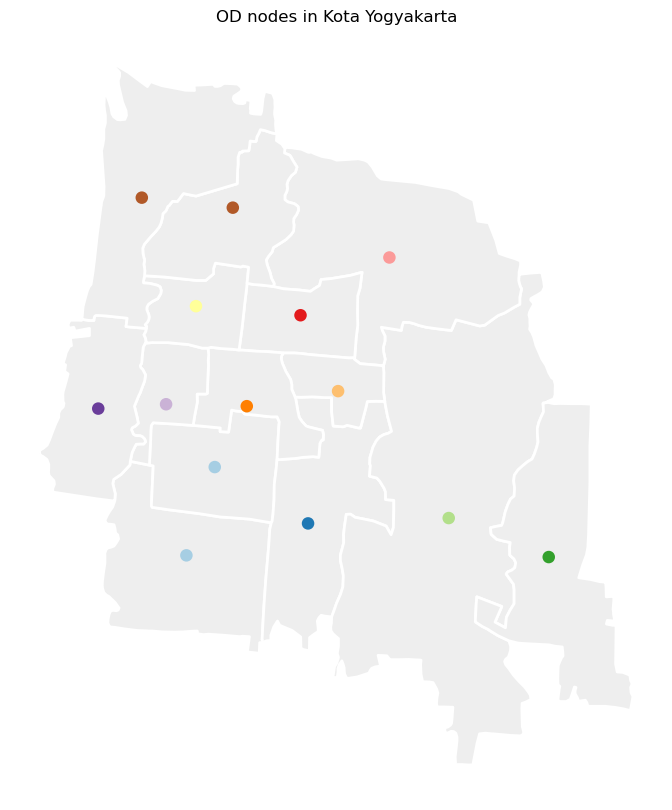

In [7]:
#It is assumed that OD nodes are in the 
# Centre Point of inner OD's polygon.
node_OD = places['geometry'].representative_point()
fig, ax = plt.subplots(figsize=(20, 10))
places.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
node_OD.plot(ax=ax, linewidth=3, alpha=1, cmap="Paired")
ax.axis("off")
ax.set_title("OD nodes in Kota Yogyakarta")

Text(0.5, 1.0, 'Titik OD di Luar Yogyakarta')

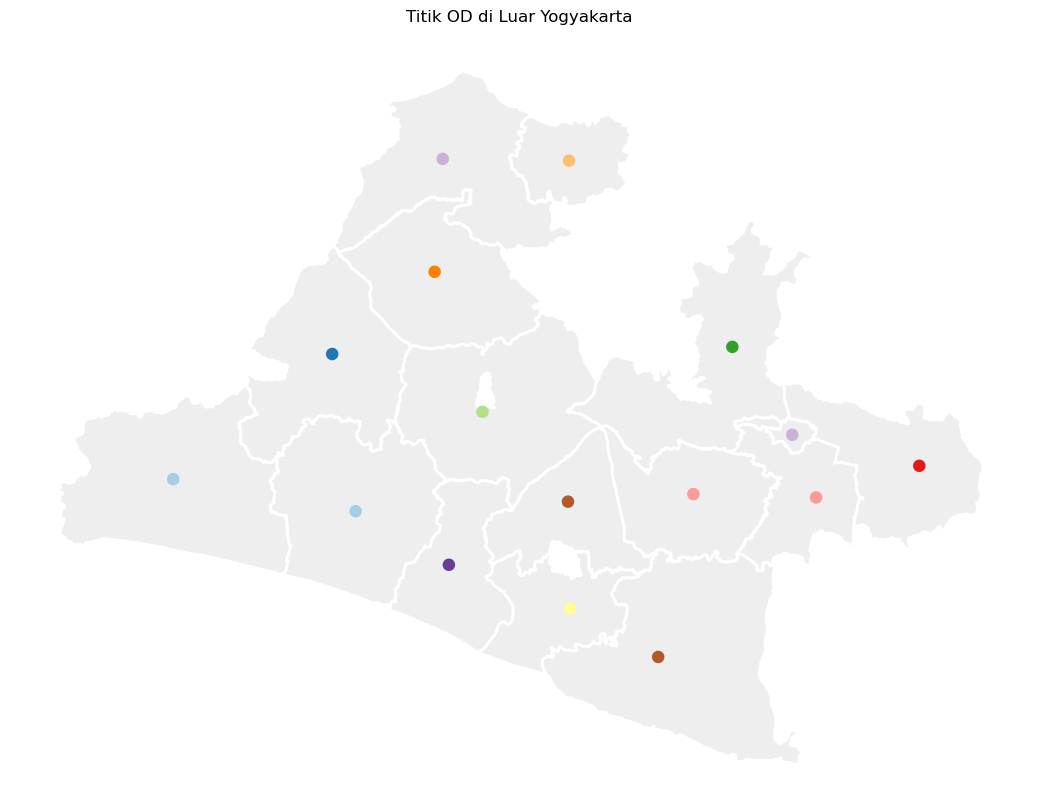

In [8]:
#For outer OD
node_OD_outer = places_outer['geometry'].representative_point()
fig, ax = plt.subplots(figsize=(20, 10))
places_outer.plot(ax=ax, facecolor="#eeeeee", edgecolor="white", alpha=1, linewidth=2)
node_OD_outer.plot(ax=ax, linewidth=3, alpha=1, cmap="Paired")
ax.axis("off")
ax.set_title("Titik OD di Luar Yogyakarta")

### Nearest Nodes of each OD

#### Inner OD

In [9]:
#Finding langitude and latitude from OD's centre point.
X = node_OD.x.values
Y = node_OD.y.values

#Nearest Nodes.
nodes_inner = pd.Series(ox.nearest_nodes(G, X, Y))

#### Outer OD

In [10]:
#Finding langitude and latitude from OD's centre point.
X = node_OD_outer.x.values
Y = node_OD_outer.y.values

#Nearest Nodes.
nodes_outer = pd.Series(ox.nearest_nodes(G, X, Y))

In [11]:
#Concatenate inner and outer ODs
nodes = pd.concat([nodes_inner, nodes_outer], ignore_index=True)

## Getting Flow From OD Matrices

In [12]:
#Tidying OD matrices
OD = pd.read_excel('OD.xlsx',sheet_name='read')
OD.columns = list(range(1,len(OD.index)+1))

### Flow function

In [13]:
def Flow_from_OD(OD):
    OD.index += 1
    OD.columns = list(range(1,len(OD.index)+1))
    if not len(OD.index) == len(OD.columns):
        raise IndexError(
            (
                "The number of origin and destination must be the same."
            )
        )
    for origin in range(1,len(OD.index)+1):
        for dests in range(1,len(OD.columns)+1):
            if origin == dests:
                yield 0
            else:
                flow = OD.iloc[origin-1 ,OD.columns.get_loc(dests)]
                yield flow              

In [14]:
%%time
#using numpy structured array
flow = np.fromiter(Flow_from_OD(pd.read_excel('OD.xlsx',sheet_name='read')), 
                   dtype=[('origin','int64'),('dests','int64'),('flow','int64')])
flow = flow['flow']


CPU times: user 113 ms, sys: 3.36 ms, total: 116 ms
Wall time: 141 ms


## Speed, Travel Times, Lane, Width and Capacity Imputation.

### Speed
The `ox.add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [15]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

### Initial Travel Times

In [16]:
# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

### Lanes

In [17]:
def add_edge_lanes(G, lanes_min=1):
    """
    Add default lanes towards NaN lanes value in edge attributes.
    It also change lanes column type into numeric.
    
    By default, this imputes 1 lane toward existing NaN values.
    
    Parameters
    ----------
    G : networkX.MultiDiGraph
        input graph
    lanes_min : int
        assigning minimum values to be inserted.
    """
    #Check if lanes_min is integer
    if not isinstance(lanes_min, int):
        raise TypeError(
            (
                "lanes_min type must be an integer."
            )
        )
    
    edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)
    
    #Change all list values in lanes colum into maximum value of lanes
    #in that list.
    edges["lanes"] = [int(max(x)) if isinstance(x, list) else x for x in edges['lanes']]
    
    #Impute missing values with lanes value.
    lanes = (
        edges[["highway", "lanes"]].set_index("highway").iloc[:, 0].fillna(lanes_min)
    )
    edges["lanes"] = lanes.values
    
    #Change lanes column into numeric
    edges['lanes']=pd.to_numeric(edges['lanes'])
    nx.set_edge_attributes(G, values=edges["lanes"], name="lanes")
    
    return G

In [18]:
G = add_edge_lanes(G)

### Width

In [19]:
def add_edge_width(G, width_min=3.5):
    """
    Add default width towards NaN width value in edge attributes.
    
    By default, this imputes 3.5 meters toward existing NaN values.
    
    Parameters
    ----------
    G : networkX.MultiDiGraph
        input graph
    width_min : int
        assigning minimum values to be inserted.
    """
    #Check if width_min is float
    if not isinstance(width_min, (float,int)):
        raise TypeError(
            (
                "width_min type must be an integer or float."
            )
        )
    
    edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)
    
    #Change all list values in lanes colum into maximum value of lanes
    #in that list.
    edges["width"] = [int(max(x)) if isinstance(x, list) else x for x in edges['width']]
    
    #Impute missing values with width value.
    width = (
        edges[["highway", "width"]].set_index("highway").iloc[:, 0].fillna(width_min)
    )
    #Change lanes column into numeric
    edges["width"]=pd.to_numeric(edges["width"])
    edges["width"] = width.values
    display(edges["width"])
    nx.set_edge_attributes(G, values=edges["width"], name="width")
    
    return G

In [20]:
G = add_edge_width(G)

u            v            key
262855957    7698514133   0      3.5
             7305115594   0        5
262855999    1664896897   0      3.5
262856002    5638791549   0      3.5
             5638791551   0      3.5
                                ... 
10108082524  8478927570   0      3.5
             1501425069   0      3.5
             10108082522  0      3.5
10125752759  6819011304   0      3.5
10125752760  5641294410   0      3.5
Name: width, Length: 15481, dtype: object

### Capacity
Imputing capacity value based on modification of 'ox.add_edge_travel_times()'.
The capacity is based on lane width and lane numbers.
The value used is based on Indonesia's Highway Capacity Manual.
If there is no lane width nor lane numbers, the capacity of the edges is assumed 1650,
the capacity for 1 lane of 3.5m width.

In [21]:
def add_edge_capacity(G, base_capacity=None, fallback=1650):
    """
    Add edge capacity to graph as new "capacity" edge attributes.
    
    By default, this imputes 1650 * number of lane toward existing 
    NaN values.
    
    Parameters
    ----------
    G : networkX.MultiDiGraph
        input graph
    base_capacity : dict
        dict keys = OSM highway types and values = typical capacity
        to assign to edges of that highway type for any edges missing
        capacity data. Any edges with highway type not in `base_capacity` 
        will be assigned the fallback value.
    fallback : numeric
        default capacity value to assign to edges whose highway
        type did not appear in `base_capacity`. Default value is based on
        Indonesian Higway Capacity Manual 1997 (MKJI 1997).
    """
    
    edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, fill_edge_geometry=False)

    # collapse any highway lists (can happen during graph simplification)
    # into string values simply by keeping just the first element of the list
    edges["highway"] = edges["highway"].map(lambda x: x[0] if isinstance(x, list) else x)
    edges["capacity"] = None
    # if user provided base_capacity, use them as default values, otherwise
    # initialize an empty series to populate with fallback values.
    if base_capacity is None:
        capacity_avg = pd.Series(dtype=float).fillna(fallback)
    else:
        capacity_avg = pd.Series(base_capacity).dropna()
    
    # for each highway type that caller did not provide in base_capacity, impute
    # capacity of type by using fallback values
    for cap, group in edges.groupby("highway"):
        if cap not in capacity_avg:
            capacity_avg.loc[cap] = fallback
    
    #Impute missing values with lanes value.
    capacity = (
        edges[["highway", "capacity"]].set_index("highway").iloc[:, 0].fillna(capacity_avg)
    )
    edges["capacity"] = capacity.round(0).values * edges["lanes"]
    nx.set_edge_attributes(G, values=edges["capacity"], name="capacity")
    
    return G

In [22]:
G = add_edge_capacity(G)

## Flatten OSMid

In [23]:
def flatten_osmid(G):
    df = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)
    #Flatten the osmid, can happen during simplification.
    df['osmid'] = df['osmid'].map(lambda x: x[0] if isinstance(x, list) else x).values
    df["highway"] = df["highway"].map(lambda x: x[0] if isinstance(x, list) else x).values
    nx.set_edge_attributes(G, df['osmid'], name='osmid')
    nx.set_edge_attributes(G, df["highway"], name="highway")
    return G  

In [24]:
#Flatten osmid
G = flatten_osmid(G)
#Convert networkX graph into GeoDataFrame.
list_jalan = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)
#Summary of the number of highway based on the highway type.
list_jalan.groupby("highway",dropna=False)[["length", "speed_kph", "travel_time","lanes","width"]].size()
list_jalan

osmid  oneway                  name  \
u           v           key                                             
262855957   7698514133  0     824465136    True  Jalan Urip Sumoharjo   
            7305115594  0     933729436    True         Jalan Affandi   
7698514133  1264446512  0      24277036    True  Jalan Urip Sumoharjo   
7305115594  1527609746  0     131706631    True         Jalan Affandi   
            7698514133  0     824465135    True  Jalan Urip Sumoharjo   
...                                 ...     ...                   ...   
10076658464 10076658463 0    1101031523   False                  Jawa   
10079030142 10079030141 0    1101371742   False        Mangga Gang II   
10079585805 10079585803 0    1101438037   False          Gang Setyaki   
10088696207 10088696206 0    1102515149   False                   NaN   
10093718312 10093718311 0    1103043963   False            Gang Jambu   

                                  highway reversed   length  speed_kph  \
u           v           key                                              
262855957   7698514133  0         primary    False    8.843       40.0   
            7305115594  0         primary    False    7.396       40.0   
7698514133  1264446512  0         primary    False   48.641       40.0   
7305115594  1527609746  0         primary    False  189.254       40.0   
            7698514133  0         primary    False    9.463       40.0   
...                                   ...      ...      ...        ...   
10076658464 10076658463 0    unclassified     True   48.583       30.0   
10079030142 10079030141 0    unclassified     True   65.285       30.0   
10079585805 10079585803 0    unclassified     True   79.700       30.0   
10088696207 10088696206 0    unclassified     True   43.065       30.0   
10093718312 10093718311 0    unclassified     True   31.859       30.0   

                             travel_time  lanes width  capacity  \
u           v           key                                       
262855957   7698514133  0            0.8      1   3.5      1650   
            7305115594  0            0.7      2     5      3300   
7698514133  1264446512  0            4.4      1   3.5      1650   
7305115594  1527609746  0           17.0      2     5      3300   
            7698514133  0            0.9      1   3.5      1650   
...                                  ...    ...   ...       ...   
10076658464 10076658463 0            5.8      1   3.5      1650   
10079030142 10079030141 0            7.8      1   3.5      1650   
10079585805 10079585803 0            9.6      1   3.5      1650   
10088696207 10088696206 0            5.2      1   3.5      1650   
10093718312 10093718311 0            3.8      1   3.5      1650   

                                                                      geometry  \
u           v           key                                                      
262855957   7698514133  0    LINESTRING (432488.390 -860369.437, 432480.094...   
            7305115594  0    LINESTRING (432488.390 -860369.437, 432488.523...   
7698514133  1264446512  0    LINESTRING (432480.094 -860366.376, 432464.713...   
7305115594  1527609746  0    LINESTRING (432488.523 -860362.085, 432519.084...   
            7698514133  0    LINESTRING (432488.523 -860362.085, 432480.094...   
...                                                                        ...   
10076658464 10076658463 0    LINESTRING (433410.995 -862569.592, 433363.525...   
10079030142 10079030141 0    LINESTRING (434364.599 -865843.929, 434303.532...   
10079585805 10079585803 0    LINESTRING (433976.281 -865312.769, 434022.910...   
10088696207 10088696206 0    LINESTRING (432442.399 -865939.040, 432436.772...   
10093718312 10093718311 0    LINESTRING (432160.351 -865068.008, 432159.390...   

                            junction bridge maxspeed tunnel access  ref  
u           v           key                                              
262855957   7698514133  0        N

# Process Algorithm

## Shortest Path

### Routing with  OSMNx

In [25]:
def OD_nodes_list(nodes_OD):
    for index, origin in nodes_OD.items():
        for index, dests in nodes_OD.items():
            yield (origin,dests)

In [26]:
# G.get_edge_data(u, v) -> taking the edge attribute from node u to v

def link_flow(G, routes, k, flow, flow_type):
    t = 'travel_time'
    if routes[k] is None:
        return G
    else:
        for i in range(len(routes[k])-1):
            minimum = G[routes[k][i]][routes[k][i+1]][0][t]
            j = 0
            keys = 0
            for j in range(len(G.get_edge_data(routes[k][i], routes[k][i+1]))):
                if G.get_edge_data(routes[k][i], routes[k][i+1], j)[t] < minimum:
                    minimum = G.get_edge_data(routes[k][i], routes[k][i+1], j)[t]
                    keys = j
            link_flow = flow + G[routes[k][i]][routes[k][i+1]][keys][flow_type]
            attrs = {(routes[k][i], routes[k][i+1], keys): {flow_type: link_flow}}
            nx.set_edge_attributes(G, attrs)
        return G

In [27]:
def OD_shortest_path(G, nodes_OD, flow_list, flow_type='flow'):
    nx.set_edge_attributes(G, 0, flow_type)
    nodes = pd.DataFrame(list(OD_nodes_list(nodes_OD)))
    routes = ox.shortest_path(G, nodes.iloc[:,0], nodes.iloc[:,1], weight="travel_time", cpus=None)
    for i in range(len(routes)):
        link_flow(G,routes, i, flow[i], flow_type)
    return G

### Initial Shortest Path

In [28]:
%%time
#Testing Shortest Path results.
OD_shortest_path(G, nodes, flow, flow_type='flow')
list_jalan = ox.utils_graph.graph_to_gdfs(G, nodes=False)
display(list_jalan)

osmid  oneway                  name  \
u           v           key                                             
262855957   7698514133  0     824465136    True  Jalan Urip Sumoharjo   
            7305115594  0     933729436    True         Jalan Affandi   
262855999   1664896897  0     153857840    True                   NaN   
262856002   5638791549  0     153857844    True                   NaN   
            5638791551  0     237087258   False                   NaN   
...                                 ...     ...                   ...   
10108082524 8478927570  0     912748083   False                   NaN   
            1501425069  0     912748083   False                   NaN   
            10108082522 0    1104602816   False                   NaN   
10125752759 6819011304  0     727640442   False                   NaN   
10125752760 5641294410  0    1106548173   False                   NaN   

                                  highway reversed  length  speed_kph  \
u           v           key                                             
262855957   7698514133  0         primary    False   8.843       40.0   
            7305115594  0         primary    False   7.396       40.0   
262855999   1664896897  0       secondary    False  15.948       54.9   
262856002   5638791549  0       secondary    False   9.980       54.9   
            5638791551  0       secondary     True   5.543       54.9   
...                                   ...      ...     ...        ...   
10108082524 8478927570  0     residential    False  53.722       23.3   
            1501425069  0     residential     True  58.271       23.3   
            10108082522 0    unclassified     True  54.791       30.0   
10125752759 6819011304  0     residential    False  42.816       23.3   
10125752760 5641294410  0     residential     True  41.213       23.3   

                             travel_time  lanes width  capacity   flow  \
u           v           key                                              
262855957   7698514133  0            0.8      1   3.5      1650      0   
            7305115594  0            0.7      2     5      3300      0   
262855999   1664896897  0            1.0      2   3.5      3300   6308   
262856002   5638791549  0            0.7      1   3.5      1650    987   
            5638791551  0            0.4      1   3.5      1650  12740   
...                                  ...    ...   ...       ...    ...   
10108082524 8478927570  0            8.3      1   3.5      1650      0   
            1501425069  0            9.0      1   3.5      1650      0   
            10108082522 0            6.6      1   3.5      1650      0   
10125752759 6819011304  0            6.6      1   3.5      1650      0   
10125752760 5641294410  0            6.4      1   3.5      1650      0   

                               junction  \
u           v           key               
262855957   7698514133  0           NaN   
            7305115594  0           NaN   
262855999   1664896897  0    roundabout   
262856002   5638791549  0           NaN   
            5638791551  0           NaN   
...                                 ...   
10108082524 8478927570  0           NaN   
            1501425069  0           NaN   
            10108082522 0           NaN   
10125752759 6819011304  0           NaN   
10125752760 5641294410  0           NaN   

                                                                      geometry  \
u           v           key                                                      
262855957   7698514133  0    LINESTRING (110.38770 -7.78311, 110.38762 -7.7...   
            7305115594  0    LINESTRING (110.38770 -7.78311, 110.38770 -7.7...   
262855999   1664896897  0    LINESTRING (110.35937 -7.78737, 110.35943 -7.7...   
262856002   5638791549  0    LINESTRING (110.35753 -7.78934, 110.35750 -7.7...   
            5638791551  0    LINESTRING (110.35753 -7.78934, 110.35747 -7.7...   
...                                  

CPU times: user 11.6 s, sys: 339 ms, total: 12 s
Wall time: 23.1 s


## Updating Travel Time

### Initialize Initial Travel Time

In [29]:
## 
def add_edge_initial_travel_time(G):
    df = nx.to_pandas_edgelist(G, edge_key='ekey').set_index(["source","target","ekey"])
    df['initial_travel_time'] = df['travel_time'].values
    nx.set_edge_attributes(G, df['initial_travel_time'], name='initial_travel_time')
    return G  

### Update travel time based on LPR Function

In [30]:
## 
def update_travel_time_lpr(G, alpha=0.15, beta=4):
    df = nx.to_pandas_edgelist(G, edge_key='ekey').set_index(["source","target","ekey"])
    df['travel_time'] = df.apply(lambda x: lpr(x, alpha, beta), axis=1).values
    nx.set_edge_attributes(G, df['travel_time'], name='travel_time')
    return G

### Link Performance Function

In [31]:
#This is a link performance function derived from Indonesia's Highway Manual (MKJI 1997).
def lpr(row, alpha=0.15,beta=4):
    if np.isnan(row['flow']):
        return row['travel_time']
    else:
        try:
            return row['initial_travel_time']*(1+alpha*(row['flow']/row['capacity'])**beta)
        except ValueError:
            return row['travel_time']

## Bisection Method

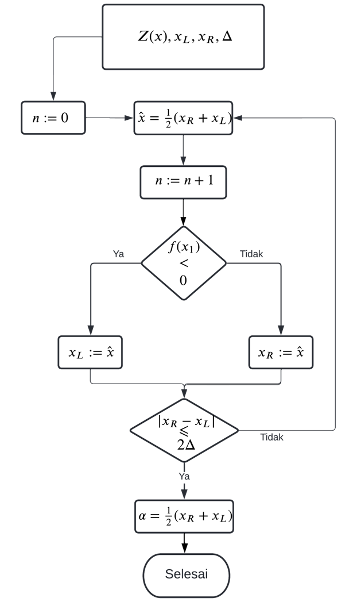

In [32]:
def line_search(row, a, alpha, beta):
    t=row['initial_travel_time']
    x=row['flow']
    y=row['auxflow']
    c=row['capacity']
    return -t*(x-y)*(alpha*(((x+a*(y-x))/c)**beta)+1)

In [33]:
def bisection(G, xl=0, xr=1, delta=0.0002, alpha=0.15, beta=4):
    n = 0
    df = nx.to_pandas_edgelist(G)
    condition = True
    while condition:
        n += 1
        x = (xl+xr)/2
        if df.apply(lambda row: line_search(row, x, alpha=alpha, beta=beta), axis = 1).sum() <= 0:
            xl = x
        else:
            xr = x
        condition = abs(xr-xl) > 2*delta
        # print('|xl-xr| =', abs(xr-xl),' xl =', xl, ' xr=',xr)
    # print(f"number of iteration in bisection method is {n} with alpha = {(xr+xl)/2}")
    return (xr+xl)/2

## Updating Mainflow from Previous Flow, Aux Flow and Optimal Move Size (alpha)

In [34]:
def update(row, alpha):
    return row['flow'] + alpha * (row['auxflow'] - row['flow'])

In [35]:
def update_mainflow(G, alpha):
    df = nx.to_pandas_edgelist(G, edge_key='ekey').set_index(["source","target","ekey"])
    df['flow'] = df.apply(lambda row: update(row, alpha), axis=1).values
    nx.set_edge_attributes(G, df['flow'], name='flow')
    return G  

# User Equilibrium / Convex Combinations Algorithm

In [36]:
#Initializing flow
flow = np.fromiter(Flow_from_OD(pd.read_excel('OD.xlsx',sheet_name='read')), 
                   dtype=[('origin','int64'),('dests','int64'),('flow','int64')])
flow = flow['flow']


In [37]:
G = ox.graph.graph_from_place("Kota Yogyakarta, Indonesia", network_type='drive', simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = add_edge_lanes(G)
G = add_edge_width(G)
G = add_edge_capacity(G)
G = flatten_osmid(G)

u            v            key
262855957    7698514133   0      3.5
             7305115594   0        5
262855999    1664896897   0      3.5
262856002    5638791549   0      3.5
             5638791551   0      3.5
                                ... 
10108082524  8478927570   0      3.5
             1501425069   0      3.5
             10108082522  0      3.5
10125752759  6819011304   0      3.5
10125752760  5641294410   0      3.5
Name: width, Length: 15481, dtype: object

In [38]:
def CCA(G, nodes, flow, convergence, alpha=0.15, alpha=4):
    
    #Initialize initial time_travel column based on travel time column 
    #from ox.add_edge_travel_times
    G = add_edge_initial_travel_time(G)
    
    # Initialize flow from OD Matrices, do shortest path
    # and Assign flow to all links.
    G = OD_shortest_path(G, nodes, flow, flow_type='flow')
    
    condition = True

    while condition == True:

        #Update travel time
        G = update_travel_time_lpr(G, alpha, beta)

        # Initialize flow from OD Matrices, do shortest path
        # and calculate auxiliary flow.
        G = OD_shortest_path(G, nodes, flow, flow_type='auxflow')

        # line search using bisection method
        alpha = bisection(G, alpha=alpha, beta=beta)
        if alpha < convergence:
            condition = False
        
        #updating mainflow based on optimal move size and auxflow
        G = update_mainflow(G, alpha)
    return G

SyntaxError: non-default argument follows default argument (824612275.py, line 1)

In [ ]:
ue = user_equilibrium(jalan_jogja, pd.read_excel('OD.xlsx',sheet_name='read'), nodes )

NameError: name 'user_equilibrium' is not defined

# 7. Validation Test

## Method 1: Scalable Quality Value Method

In [ ]:
#MGEH
def mgeh(arr_obs, arr_model):
    return np.sqrt(np.square(arr_model-arr_obs)/arr_obs)

#scaling factor
def scaling_factor(arr_obs):
    return np.ma.average(arr_obs)

#normal sqv
def n_sqv(arr_obs, arr_model, arr_corr=1):
    if type(arr_corr) is np.ndarray:
        arr_corr=arr_corr/arr_obs
    return 1/(1+np.sqrt(np.square(arr_model-arr_obs)/
            (np.ma.average(arr_obs)*arr_obs*arr_corr)))



## Method 2: Root Mean Square Error

In [ ]:
def RMSE(actual,predicted):
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE

<b>Integration needed </b>

In [ ]:
#SQV standard deviation
std_sqv=mgeh(observed,modeled)*np.sqrt(observed)
print(std_sqv)

[0.1 0.6 0.2 0.4 0.8 1.3 0.2 0.1 0.3 0.2]


In [ ]:
#Normal standard deviation
std=np.std(observed)
print(std)

2.8722813232690143


In [ ]:
#implicit standard deviation - mgeh standard deviation
np.std(observed)-(mgeh(observed,modeled)*np.sqrt(observed))

array([2.77228132, 2.27228132, 2.67228132, 2.47228132, 2.07228132,
       1.57228132, 2.67228132, 2.77228132, 2.57228132, 2.67228132])

In [ ]:
#0+
observed_plus=observed+np.maximum(0,np.std(observed)
                      -(mgeh(observed,modeled)*np.sqrt(observed)))
print(observed)

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
#Margin of Error
def rSamplingErr(arr_obs,z=1.44):
    return z*np.std(arr_obs)/math.sqrt(len(arr_obs)/np.mean(arr_obs)

SyntaxError: invalid syntax (816697539.py, line 4)

In [ ]:
rSamplingErr(observed)

0.23780817326729384

In [ ]:
observed_Splus=observed_plus*(1+rSamplingErr(observed))
print(observed_Splus)

[ 4.66936065  5.28826474  7.02119618  8.01144272  8.75412763  9.37303171
 11.97242888 13.33401787 14.32426441 15.6858534 ]


In [ ]:
#compate modified n_sqv and manually calculate corrected sqv
print(n_sqv(observed, modeled,observed_Splus))

c_sqv=1/(1+np.sqrt(np.square(modeled-observed)/
            (np.ma.average(observed)*observed_Splus)))
print(c_sqv)

[0.98064899 0.89988476 0.9688193  0.94316561 0.89662553 0.8466972
 0.97594622 0.9884576  0.96730603 0.97892137]
[0.98064899 0.89988476 0.9688193  0.94316561 0.89662553 0.8466972
 0.97594622 0.9884576  0.96730603 0.97892137]
